# Image segmentation model trained from scratch on the Oxford Pets dataset with a U-Net-like architecture

**Author:** [Ashaduzzaman Sarker](https://github.com/ashaduzzaman-sarker)
<br>
**Date created:** 02/07/2024
<br>
**Reference:**
- [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://doi.org/10.48550/arXiv.1505.04597)

- [Keras](https://keras.io/examples/vision/oxford_pets_image_segmentation/)


## Download the Oxford Pets data

In [1]:
!!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!
!curl -O https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
!curl -O https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz
!
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  15.3M      0  0:00:49  0:00:49 --:--:-- 16.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  4347k      0  0:00:04  0:00:04 --:--:-- 4348k


## Prepare paths of input images and target segmentation masks

In [2]:
import os

input_dir = 'images/'
target_dir = 'annotations/trimaps/'
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith('.jpg')
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith('.png') and not fname.startswith('.')
    ]
)

print('Number of samples:', len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, '|', target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


## What does one input image and corresponding segmentation mask look like?

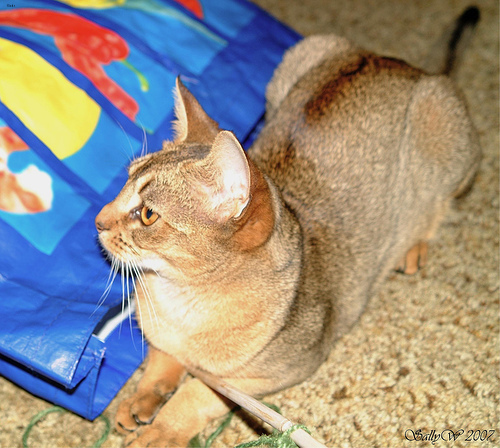

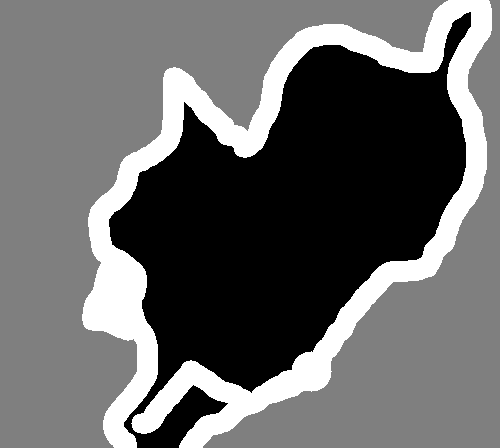

In [3]:
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps

# Display input image
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target
img = ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

## Prepare dataset to load & vectorize batches of data

In [4]:
import keras
import numpy as np
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io

def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    # Returns a TF Dataset

    def load_img_masks(input_img_path, target_img_path):
      input_img = tf_io.read_file(input_img_path)
      input_img = tf_io.decode_png(input_img, channels=3)
      input_img = tf_image.resize(input_img, img_size)
      input_img = tf_image.convert_image_dtype(input_img, 'float32')

      target_img = tf_io.read_file(target_img_path)
      target_img = tf_io.decode_png(target_img, channels=1)
      target_img = tf_image.resize(target_img, img_size, method='nearest')
      target_img = tf_image.convert_image_dtype(target_img, 'uint8')

      # Ground Truth label are 1, 2, 3. Subtract one to make them 0, 1, 2:
      target_img -= 1
      return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
      input_img_paths = input_img_paths[:max_dataset_len]
      target_img_paths = target_img_paths[:max_dataset_len]

    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)


## Prepare U-Net Xception-style model

In [8]:
from keras import layers

def get_model(img_size, num_classes):
  inputs = keras.Input(shape=img_size + (3,))

  ### [First half of the network: downsampling inputs]

  # Entry block
  x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  previous_block_activation = x  # Set aside residual

  # Blocks 1, 2, 3 are identical apart from the feature depth
  for filters in [64, 128, 256]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Project Residual
    residual = layers.Conv2D(filters, 1, strides=2, padding='same')(
        previous_block_activation
    )
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

  ### [Second half of the network: upsampling inputs]

  for filters in [256, 128, 64, 32]:
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D(2)(x)

    # Project residual
    residual = layers.UpSampling2D(2)(previous_block_activation)
    residual = layers.Conv2D(filters, 1, padding='same')(residual)
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

  # Add a per-pixel classification layer
  outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

  # Define the model
  model = keras.Model(inputs, outputs)
  return model

# Build the model
model = get_model(img_size, num_classes)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv2d_13 (Conv2D)          (None, 80, 80, 32)           896       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_21 (Ba  (None, 80, 80, 32)           128       ['conv2d_13[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_21 (Activation)  (None, 80, 80, 32)           0         ['batch_normalization_21

## Set aside a validation split

In [10]:
import random

# Split our img paths into a training and validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]

val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate dataset for each split
# Limit input files in `max_dataset_len` for faster training time
# Remove the `max_dataset_len` arg when running with full dataset
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=1000,
)

valid_dataset = get_dataset(
    batch_size,
    img_size,
    val_input_img_paths,
    val_target_img_paths,
)

## Train the Model

In [12]:
# Configure the model for training
# We use the 'sparse' version of categorical_crossentropy, because our target data is integers

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
)

callbacks = [
    keras.callbacks.ModelCheckpoint('oxford_segmentation.keras', save_best_only=True)
]

# Train the model, doing validation at the end of each epoch
epochs = 10 # 50
model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/10
32/32 - 353s - loss: 0.6378 - val_loss: 2.2328 - 353s/epoch - 11s/step
Epoch 2/10
32/32 - 330s - loss: 0.5630 - val_loss: 2.2979 - 330s/epoch - 10s/step
Epoch 3/10
32/32 - 340s - loss: 0.5285 - val_loss: 2.4206 - 340s/epoch - 11s/step
Epoch 4/10
32/32 - 339s - loss: 0.4952 - val_loss: 2.5614 - 339s/epoch - 11s/step
Epoch 5/10
32/32 - 339s - loss: 0.4645 - val_loss: 2.6934 - 339s/epoch - 11s/step
Epoch 6/10
32/32 - 338s - loss: 0.4346 - val_loss: 2.7861 - 338s/epoch - 11s/step
Epoch 7/10
32/32 - 338s - loss: 0.4069 - val_loss: 2.7298 - 338s/epoch - 11s/step
Epoch 8/10
32/32 - 338s - loss: 0.3861 - val_loss: 2.5548 - 338s/epoch - 11s/step
Epoch 9/10
32/32 - 331s - loss: 0.3690 - val_loss: 2.2694 - 331s/epoch - 10s/step
Epoch 10/10
32/32 - 337s - loss: 0.3721 - val_loss: 1.6681 - 337s/epoch - 11s/step


## Visualize Predictions

32/32 [==============================] - 76s 2s/step


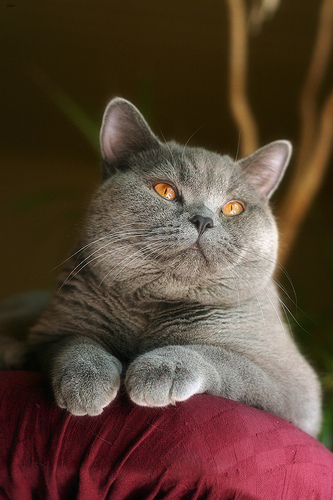

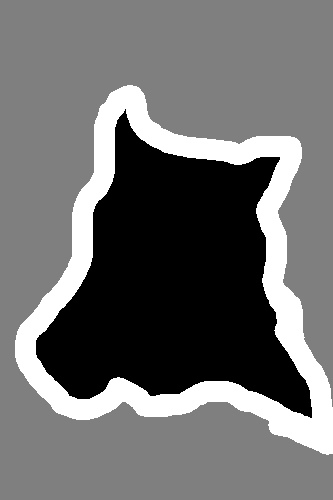

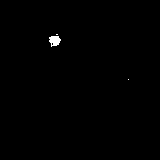

In [14]:
# Generate predictions for all images in the validation set

val_dataset = get_dataset(
    batch_size,
    img_size,
    val_input_img_paths,
    val_target_img_paths,
)

val_preds = model.predict(val_dataset)

def display_mask(i):
  ## Quick utility to display a model's prediction
  mask = np.argmax(val_preds[i], axis=-1)
  mask = np.expand_dims(mask, axis=-1)
  img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
  display(img)

# Display results for validation image (10)
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)